In [1]:

import numpy as np
import pandas as pd

In [57]:
data1 = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';')

In [2]:
data = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';')
# готовим некоторые данные
data['score_shk'] = data['score_shk'].str.replace(',','.').astype(float)
data['credit_sum'] = data['credit_sum'].str.replace(',','.').astype(float)
# преобразуем указанные переменные в тип object
for i in ['tariff_id']:
    data[i] = data[i].astype('object')
data['living_region'] = data['living_region'].astype(str)
from_replace = ['\s?(ОБЛАСТЬ|ОБЛ\.|ОБЛ|КРАЙ\.|КРАЙ|РЕСПУБЛИКА|РЕСП\.|РЕСП|Г\.\s|Г\s|\sГ|АО|Р-Н)\s?', '74',
                '98|САНКТ-ПЕТЕРБУРГ', 'ЕВРЕЙСКАЯБЛ', 'КАМЧАТСКАЯ|КАМЧАТС\?\?ИЙ', '(МОСКВА|МОСКВОСКАЯ|МЫТИЩИНСКИЙ)',
                '(САХА \(ЯКУТИЯ\)|САХА \/ЯКУТИЯ\/)', 'СЕВ\. ОСЕТИЯ - АЛАНИЯ', 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- ЮГРА',
                'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- Ю', '(ЧУВАШИЯ\sЧУВАШСКАЯ-|ЧУВАШСКАЯ\s?-\sЧУВАШИЯ)', 'БЛ ЕВРЕЙСКАЯ', 
                'БРЯНСКИЙ', 'ГОРЬКОВСКАЯ', 'ОРЁЛ', 'ПЕРМСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ЭВЕНКИЙСКИЙ', 
                'nan|ГУСЬ-ХРУСТАЛЬНЫЙ|МОСКОВСКИЙ\sП|РОССИЯ', 'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА', 'ЧЕЛЯБИНСК$', 'ЧИТИНСКАЯ',
                'ЧУКОТСКИЙ\sАO', 'Г.МОСКОВСКАЯ', 'Г.ОДИНЦОВО\sМОСКОВСКАЯ', 'ДАЛЬНИЙ\sВОСТОК']
to_replace = ['', 'ЧЕЛЯБИНСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'КАМЧАТСКИЙ', 'МОСКОВСКАЯ', 'САХА', 'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
              'ХАНТЫ-МАНСИЙСКИЙ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧУВАШСКАЯ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
              'БРЯНСКАЯ', 'НИЖЕГОРОДСКАЯ', 'ОРЛОВСКАЯ', 'ПЕРМСКИЙ', 'МОСКОВСКАЯ', 'КРАСНОЯРСКИЙ', 
              'МОСКОВСКАЯ', 'ХАНТЫ-МАНСИЙСКИЙ', 'ЧЕЛЯБИНСКАЯ', 'ЗАБАЙКАЛЬСКИЙ', 'ЧУКОТСКИЙ', 
              'МОСКОВСКАЯ', 'МОСКОВСКАЯ', 'ПРИМОРСКИЙ']
data['living_region'].replace(from_replace, to_replace, regex=True, inplace=True)
    
    
data.at[data['job_position'] == 'PNV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'PNS', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'HSK', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'INV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'ONB', 'job_position'] = 'OTHER'
data.loc[data['tariff_id'].value_counts()[data['tariff_id']].values < 55, 
         'tariff_id'] = '1.99'
    
region_series = data['living_region'].value_counts()
mask = (region_series/region_series.sum() * 100).lt(0.029)
data['living_region'] = np.where(data['living_region'].isin(region_series[mask].index), 
                                 'OTHER', data['living_region'])
data['age'].fillna(data['age'].median(), inplace=True)
for i in ['credit_sum', 'score_shk']:
    data[i].fillna(data[i].median(), inplace=True)
data['monthly_income'].fillna(30000.0, inplace=True)
for i in ['credit_count', 'overdue_credit_count']:
    data[i].fillna(-1, inplace=True)
data['marital_status'] = data['marital_status'].fillna('MAR')
data['education'].fillna(data['education'].value_counts().index[0], inplace=True)
data['tariff'] = data['tariff_id'].astype('float')

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
region_encoder = preprocessing.LabelEncoder()
data['living_region'] = region_encoder.fit_transform(list(data['living_region']))

In [6]:
data['living_region'] = data['living_region'].astype('category')

In [7]:
central = ['Белгородская', 'Брянская', 'Владимирская', 'Воронежская', 
         'Ивановская', 'Калужская', 'Костромская', 'Курская', 'Липецкая', 'Московская', 
           'Орловская', 'Рязанская', 'Смоленская', 'Тамбовская', 'Тверская', 'Тульская', 
           'Ярославская', 'Москва']
central = [x.upper() for x in central]

sev_zap = ['Карелия', 'Коми', 'Архангельская', 'Ненецкий', 'Вологодская', 'Калининградская', 
           'Ленинградская', 'Мурманская', 'Новгородская', 'Псковская', 'Санкт-Петербург']
sev_zap = [x.upper() for x in sev_zap]

yug = ['Адыгея', 'Калмыкия', 'Краснодарский', 'Астраханская', 'Волгоградская', 'Ростовская']
yug = [x.upper() for x in yug]

kavkaz = ['Ставропольский', 'Ингушетия', 'Дагестан', 'Чеченская', 'Кабардино-Балкарская', 
 'Карачаево-Черкесская', 'Северная Осетия']
kavkaz = [x.upper() for x in kavkaz]

volga = ['Башкортостан', 'Марий Эл', 'Мордовия', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'Татарстан', 
         'Удмуртская', 'Чувашская', 'Кировская', 'Нижегородская', 'Оренбургская', 'Пензенская', 
         'ПЕРМСКИЙ', 'Самарская', 'Саратовская', 'Ульяновская']
volga = [x.upper() for x in volga]

ural = ['Курганская', 'Свердловская', 'Тюменская', 'Челябинская', 'Ханты-Мансийский', 
        'Ямало-Ненецкий']
ural = [x.upper() for x in ural]

sibir = ['Алтай', 'Бурятия', 'Тыва', 'Хакасия', 'Алтайский', 'Забайкальский', 'Красноярский', 
         'Иркутская', 'Кемеровская', 'Новосибирская', 'Омская', 'Томская']
sibir = [x.upper() for x in sibir]

dvostok = ['Якутия', 'камчатский', 'приморский', 'хабаровский', 'амурская', 
           'магаданская', 'сахалинская', 'еврейская', 'чукотский', 'ДАЛЬНИЙ ВОСТОК']
dvostok = [x.upper() for x in dvostok]

russia = ['РОССИЯ']

In [8]:
data['fed_reg'] = 1
def label_fed_reg(x):
    if x in central:
        return 'central'
    if x in sev_zap:
        return 'sev_zap'
    if x in ural:
        return 'ural'
    if x in yug:
        return 'yug'
    if x in kavkaz:
        return 'kavkaz'
    if x in volga:
        return 'volga'
    if x in sibir:
        return 'sibir'
    if x in dvostok:
        return 'dvostok'
    if x in russia:
        return 'russia'
    else:
        return 'russia'
data['fed_reg'] = data['living_region'].apply(lambda x: label_fed_reg(x))


In [9]:
fo_encoder = preprocessing.LabelEncoder()
data['fed_reg_enc'] = fo_encoder.fit_transform(list(data['fed_reg'])).astype('int')

In [10]:
data['clean_region_freq'] = data.groupby('living_region')['living_region'].transform('count')

In [11]:
data['fed_reg_freq'] = data.groupby('fed_reg')['fed_reg'].transform('count')
data['reg_freq_fed_freq'] = data['clean_region_freq']/data['fed_reg_freq']


In [12]:
data.drop(['clean_region_freq', 'fed_reg_freq', 'living_region', 'fed_reg'], axis=1, inplace=True)

In [13]:
data['credit_divide10000'] = (data['credit_sum'] % 1000 == 0).astype('int')

In [14]:
data['credit_kopeyka'] = data['credit_sum'].astype('str').map(lambda x: int(x[-1]))

In [15]:
data['credit_kopeyka'] = (data['credit_kopeyka'] > 0).astype('int')

In [16]:
data['overdue_ratio'] = data['overdue_credit_count']/data['credit_count']
data['credit_income_ratio'] = data['credit_sum']/data['monthly_income']
data['monthly_payment'] = data['credit_sum']/data['credit_month']

In [17]:
data['overdue_ratio'].fillna(0, inplace=True)

In [18]:
data['monthly_income_sq'] = pow(data['monthly_income'], 2)

In [19]:
data['age_sq'] = pow(data['age'], 2)

In [20]:
data['credit_sum_sq'] = pow(data['credit_sum'], 2)

In [21]:
data.head(2).T

,0,1
client_id,1,2
gender,M,F
age,34,34
marital_status,MAR,MAR
job_position,UMN,UMN
credit_sum,59998,10889
credit_month,10,6
tariff_id,1.6,1.1
score_shk,0.461599,0.461599
education,GRD,SCH


In [23]:
data_dummies = pd.concat([
                        pd.get_dummies(data.gender, prefix = 'sex'),
                        pd.get_dummies(data.marital_status , prefix = 'marital'),
                        pd.get_dummies(data.job_position, prefix = 'job'),
                        pd.get_dummies(data.tariff_id , prefix = 'tariff'),
                        pd.get_dummies(data.education , prefix = 'educ'),
                        pd.get_dummies(data.fed_reg_enc , prefix = 'fed_reg'),
                        pd.get_dummies(data.fed_reg_enc , prefix = 'living_region'),
                        data.age,
                        data.age_sq,
                        data.credit_sum,
                        data.credit_sum_sq,
                        data.credit_month,
                        data.score_shk,
                        data.monthly_income,
                        data.monthly_income_sq,
                        data.credit_count,
                        data.overdue_credit_count,   
                        data.monthly_payment,
                        data.credit_income_ratio,
                        data.overdue_ratio,
                        data.credit_kopeyka,
                        data.credit_divide10000,
                        data.reg_freq_fed_freq,
                        data.open_account_flg  ], axis=1)

In [24]:
data_dummies.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq,open_account_flg
0,0,1,0,0,1,0,0,0,0,0,...,900000000.0,1.0,1.0,5999.800000,1.999933,1.0,0,0,0.048932,0
1,1,0,0,0,1,0,0,0,0,0,...,900000000.0,2.0,0.0,1814.833333,0.362967,0.0,0,0,0.130574,0
2,0,1,0,0,1,0,0,0,0,0,...,900000000.0,5.0,0.0,894.000000,0.357600,0.0,0,0,0.013365,0
3,1,0,0,0,1,0,0,0,0,0,...,900000000.0,2.0,0.0,1000.757500,0.400303,0.0,1,0,0.013828,0
4,0,1,0,0,1,0,0,0,0,0,...,900000000.0,1.0,0.0,2122.900000,0.707633,0.0,0,0,0.030191,0


In [25]:
from sklearn.model_selection import train_test_split
X = data_dummies.drop('open_account_flg', axis=1)  
y = data_dummies['open_account_flg'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2020, stratify=y)


In [39]:
columns = ['sex_F', 'sex_M', 'marital_CIV', 'marital_DIV', 'marital_MAR',
       'marital_UNM', 'marital_WID', 'job_ATP', 'job_BIS', 'job_BIU',
       'job_DIR', 'job_INP', 'job_NOR', 'job_OTHER', 'job_PNA', 'job_PNI',
       'job_SPC', 'job_UMN', 'job_WOI', 'job_WRK', 'job_WRP', 'tariff_1.0',
       'tariff_1.1', 'tariff_1.16', 'tariff_1.17', 'tariff_1.19', 'tariff_1.2',
       'tariff_1.21', 'tariff_1.22', 'tariff_1.23', 'tariff_1.24',
       'tariff_1.25', 'tariff_1.3', 'tariff_1.32', 'tariff_1.4', 'tariff_1.41',
       'tariff_1.43', 'tariff_1.44', 'tariff_1.5', 'tariff_1.6', 'tariff_1.7',
       'tariff_1.9', 'tariff_1.91', 'tariff_1.94', 'tariff_1.99', 'educ_ACD',
       'educ_GRD', 'educ_PGR', 'educ_SCH', 'educ_UGR', 'fed_reg_0',
       'living_region_0', 'age', 'age_sq', 'credit_sum', 'credit_sum_sq',
       'credit_month', 'score_shk', 'monthly_income', 'monthly_income_sq',
       'credit_count', 'overdue_credit_count', 'monthly_payment',
       'credit_income_ratio', 'overdue_ratio', 'credit_kopeyka',
       'credit_divide10000', 'reg_freq_fed_freq']

In [26]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)


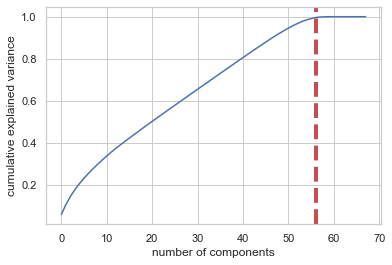

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.057611,0.057611
1,0.104132,0.046521
2,0.143307,0.039175
3,0.175700,0.032393
4,0.204596,0.028896
5,0.230239,0.025644
6,0.253563,0.023324
7,0.275700,0.022137
8,0.296590,0.020890
9,0.316704,0.020114


In [34]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components= 68)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=56, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

Итого, 56 компонентов можно считать информативными

In [35]:
pca = PCA(n_components=56)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [40]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
sex_F,-0.071550,0.031770,-0.404289,-0.355697,0.124820,0.219199,-0.073163,0.066578,0.241931,0.099356
sex_M,0.071550,-0.031770,0.404289,0.355697,-0.124820,-0.219199,0.073163,-0.066578,-0.241931,-0.099356
marital_CIV,0.002708,-0.019369,-0.018173,-0.018273,0.002521,0.054802,0.075631,-0.039063,-0.040201,-0.007778
marital_DIV,-0.043241,0.042263,-0.102347,-0.043412,0.111411,0.144542,0.187735,-0.100208,0.018218,0.113162
marital_MAR,-0.051922,0.211458,0.124077,0.107434,-0.307614,-0.075785,-0.513746,0.224807,0.230819,-0.004233
...,...,...,...,...,...,...,...,...,...,...
credit_income_ratio,0.217585,-0.084436,-0.401038,0.021132,-0.183238,-0.198084,-0.110703,-0.085346,-0.091740,-0.012504
overdue_ratio,0.077953,-0.246567,-0.003211,-0.008535,0.202142,-0.231450,-0.003190,0.326657,0.172430,-0.069248
credit_kopeyka,-0.056882,-0.042367,0.011863,0.010969,-0.033307,0.017307,0.030677,0.235851,-0.329281,0.491926
credit_divide10000,0.021273,0.013128,0.008838,-0.001608,0.007514,-0.016622,0.013704,-0.032806,0.030234,-0.067386


In [41]:
rfc = KMeans()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

-7597095.258611297

In [43]:
model_Kmeans = KMeans(n_clusters = 10,n_init = 2000)

In [44]:
X_KMeans = model_Kmeans.fit_predict(pca_test_df)

In [46]:
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [55]:
Sil2 = np.zeros((1,20))
for k in list(range(20))[2:20]:
    Sil2[0][k] = metrics.silhouette_score(pca_test_df, KMeans(n_clusters = k,n_init = 200).fit_predict(pca_test_df), metric='euclidean') 
print(Sil2)

[[0.00000000e+00 0.00000000e+00 4.77954616e-16 3.37108087e-16
  2.77075140e-16 2.86310978e-16 3.18636411e-16 3.07091613e-16
  3.62506641e-16 3.11709532e-16 3.83287277e-16 3.07091613e-16
  2.07806355e-16 3.00164735e-16 4.13303750e-16 3.37108087e-16
  3.87905196e-16 4.17921669e-16 3.64815601e-16 3.64815601e-16]]


In [52]:
model_Kmeans.cluster_centers_

array([[-7.07106777e-01, -7.07106777e-01,  2.28099443e-05,
         4.38748117e-05,  7.30045583e-05,  6.76630514e-05,
         2.06859728e-05,  2.76939958e-06,  3.87328189e-06,
         6.04736115e-07,  3.20423200e-06,  8.17491820e-07,
         1.22515849e-06,  4.13198151e-07,  3.34485782e-06,
         4.33759758e-07,  8.91004631e-06,  6.65149092e-06,
         9.93906345e-07,  1.36035693e-06,  5.50502781e-07,
         3.33234125e-07,  1.44440161e-06,  4.00060682e-07,
         1.93398196e-07,  3.23359233e-07,  2.58125608e-07,
         1.72071675e-07,  1.39073228e-07,  1.36556179e-07,
         1.22165992e-07,  5.09561443e-08,  4.07975853e-07,
         8.46676606e-07,  7.23562637e-07,  8.34432523e-08,
         4.40638074e-07,  3.37098850e-07,  6.04499852e-07,
         1.23650867e-06,  2.23201418e-07,  5.17150657e-07,
         1.25981651e-07,  1.41098943e-07,  6.31596797e-08,
         8.15548718e-09,  1.57969056e-07,  1.83343942e-08,
         1.59750958e-07,  7.51880780e-08, -1.76253053e-0

In [59]:
data1.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(X.iloc[:500, :56] , 'ward', 'euclidean')

In [100]:

link[:10]

array([[184.        , 372.        ,   2.        ,   2.        ],
       [ 15.        , 337.        ,   2.        ,   2.        ],
       [212.        , 394.        , 104.05767631,   2.        ],
       [291.        , 433.        , 112.04463396,   2.        ],
       [ 42.        , 142.        , 124.04031603,   2.        ],
       [158.        , 336.        , 216.04629134,   2.        ],
       [417.        , 501.        , 295.64618494,   3.        ],
       [113.        , 362.        , 468.04700619,   2.        ],
       [371.        , 506.        , 663.51211996,   4.        ],
       [320.        , 423.        , 803.07782935,   2.        ]])

[array([184., 372.,   2.,   2.]),
 array([ 15., 337.,   2.,   2.]),
 array([212.        , 394.        , 104.05767631,   2.        ]),
 array([291.        , 433.        , 112.04463396,   2.        ]),
 array([ 42.        , 142.        , 124.04031603,   2.        ]),
 array([158.        , 336.        , 216.04629134,   2.        ]),
 array([417.        , 501.        , 295.64618494,   3.        ]),
 array([113.        , 362.        , 468.04700619,   2.        ]),
 array([371.        , 506.        , 663.51211996,   4.        ]),
 array([320.        , 423.        , 803.07782935,   2.        ]),
 array([  4.        ,   5.        , 869.07076812,   2.        ]),
 array([ 238.        ,  266.        , 1036.09748576,    2.        ]),
 array([ 271.        ,  460.        , 1312.09984376,    2.        ]),
 array([ 295.        ,  381.        , 1548.10529358,    2.        ]),
 array([ 136.        ,  179.        , 1729.10612745,    2.        ]),
 array([1.95000000e+02, 4.40000000e+02, 2.18415521e+03, 2.

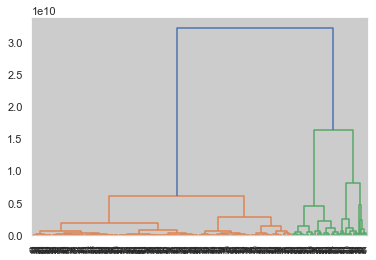

In [66]:
# Функция для построения дендрограммы
dn = dendrogram(link)

In [92]:
K = pd.DataFrame(X.iloc[:500, :56])

In [90]:
K['clusters'] = fcluster(link, 5, criterion='distance')

In [91]:
K.head(10)

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,educ_PGR,educ_SCH,educ_UGR,fed_reg_0,living_region_0,age,age_sq,credit_sum,credit_sum_sq,clusters
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,34.0,1156.0,59998.00,3.599760e+09,477
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,34.0,1156.0,10889.00,1.185703e+08,87
2,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,1,32.0,1024.0,10728.00,1.150900e+08,84
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,27.0,729.0,12009.09,1.442182e+08,127
4,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,1,45.0,2025.0,21229.00,4.506704e+08,290
5,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,34.0,1156.0,21229.00,4.506704e+08,291
6,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,1,34.0,1156.0,10317.00,1.064405e+08,91
7,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,26.0,676.0,47878.00,2.292303e+09,448
8,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,23.0,529.0,37577.16,1.412043e+09,415
9,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,32.0,1024.0,26268.00,6.900078e+08,337


In [83]:
dist = link[:, 2]
dist

array([2.00000000e+00, 2.00000000e+00, 1.04057676e+02, 1.12044634e+02,
       1.24040316e+02, 2.16046291e+02, 2.95646185e+02, 4.68047006e+02,
       6.63512120e+02, 8.03077829e+02, 8.69070768e+02, 1.03609749e+03,
       1.31209984e+03, 1.54810529e+03, 1.72910613e+03, 2.18415521e+03,
       1.43542256e+04, 2.63680684e+04, 2.66945126e+04, 2.81220904e+04,
       2.91454331e+04, 3.70402601e+04, 4.29198661e+04, 4.37290632e+04,
       4.40629513e+04, 4.44399503e+04, 4.61730396e+04, 5.00244595e+04,
       5.02576503e+04, 5.91413340e+04, 6.02493654e+04, 6.24762153e+04,
       6.26051516e+04, 6.50012566e+04, 7.03249611e+04, 7.05521533e+04,
       7.69694720e+04, 8.99820957e+04, 1.11294259e+05, 1.11488301e+05,
       1.17684040e+05, 1.18766475e+05, 1.26305185e+05, 1.64671491e+05,
       1.90342145e+05, 2.30708777e+05, 2.31563709e+05, 2.34022766e+05,
       2.34066109e+05, 2.46260198e+05, 2.52568832e+05, 2.52853167e+05,
       2.59752808e+05, 2.61500738e+05, 2.63659037e+05, 2.80598504e+05,
      

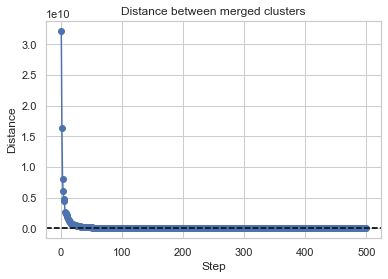

In [88]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(8, c='k', linestyle='dashed')
plt.axhline(8, c='k', linestyle='dashed')
